# 2025-03-10 2D RK ctd + advection-diffusion

## Last time

* Stiffness
* Stability 
* Runge-Kutta methods


## Today

* 3/3 lecture exercises + effective stability reminder
* Embedded RK methods
* Adaptive stepsize control
* Implicit methods
* Exploring/discussing tradeoffs
* SciML benchmarks suite (`DifferentialEquations.jl`)
* FD methods in 2D

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end
    
#function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
#    x = LinRange(xlims[1], xlims[2], 100)
#    y = LinRange(ylims[1], ylims[2], 100)
#    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
#end


function plot_stability(Rz, title; xlims=(-3, 3), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
    
function rk_eff_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    fsal = rk.b[1,:] ≈ rk.A[end,:]
    z = (s - fsal) * z
    1 + z * rk.b[brow,:]' * ((I - z*rk.A) \ ones(s))
end
    
struct RKTable
    A::Matrix
    b::Matrix
    c::Vector
    function RKTable(A, b)
        s = size(b, 2)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end


function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1 2 2 1] / 6)
    
function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Reminder: effective stability

* Having $s$ stages is like having an effective stepsize of $h/s$ ($s$ "stops along the way"),
* For FSAL methods, $s-1$ effective stages, since last one is reused
* For fair comparison of effort, therefore, want to compare $s$-stage method with stepsize $h$ to 1-stage method of stepsize $hs$:
 $$ z \to \begin{cases} (s-1)z \quad &\text{if FSAL,}  \\ sz \quad &\text{otherwise.} \end{cases} $$

In [22]:
function rk_eff_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    fsal = rk.b[1,:] ≈ rk.A[end,:]
    z = (s - fsal) * z
    1 + z * rk.b[brow,:]' * ((I - z*rk.A) \ ones(s))
end

rk_eff_stability (generic function with 1 method)

# Embedded error estimation

It is often possible to design Runge-Kutta methods with multiple completion orders, say of order $p$ and $p-1$.

$$\left[ \begin{array}{c|c} c & A \\ \hline & b^T  \\ & \tilde b^T \end{array} \right] . $$

The classical RK4 does not come with an embedded method, but most subsequent RK methods do. The [Bogacki-Shampine method](https://en.wikipedia.org/wiki/Bogacki%E2%80%93Shampine_method) is one such method.

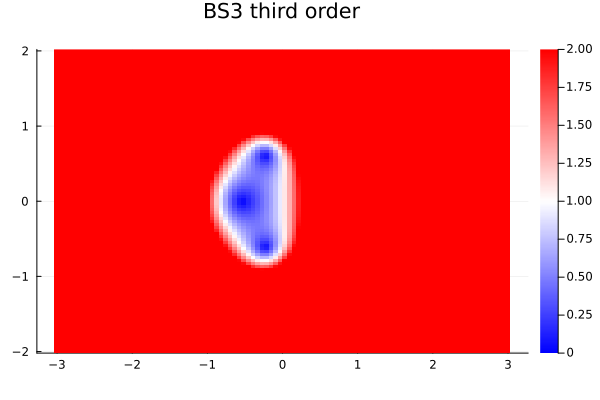

In [2]:
bs3 = RKTable([0 0 0 0; 1/2 0 0 0; 0 3/4 0 0; 2/9 1/3 4/9 0],
    [2/9 1/3 4/9 0; 7/24 1/4 1/3 1/8])
plot_stability(z -> rk_eff_stability(z, bs3), "BS3 third order")

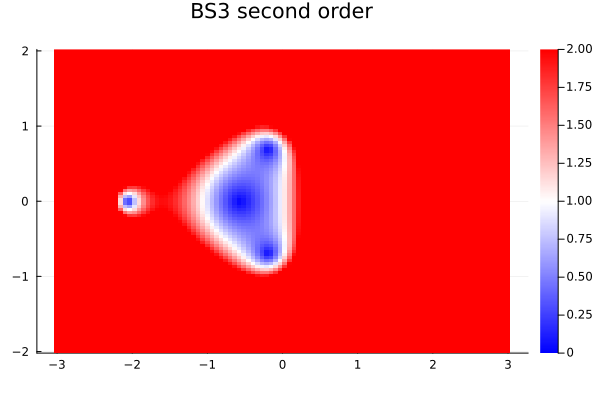

In [4]:
plot_stability(z -> rk_eff_stability(z, bs3, brow=2), "BS3 second order")

# Properties

In [23]:
display(bs3.A)
display(bs3.b)

4×4 Matrix{Float64}:
 0.0       0.0       0.0       0.0
 0.5       0.0       0.0       0.0
 0.0       0.75      0.0       0.0
 0.222222  0.333333  0.444444  0.0

2×4 Matrix{Float64}:
 0.222222  0.333333  0.444444  0.0
 0.291667  0.25      0.333333  0.125

* **Question**: Is this explicit or implicit?

* First same as last (FSAL): the completion formula $b$ is the same as the last row of $A$.
  * Stage can be reused as first stage of the next time step. So this 4-stage method has a cost equal to a 3-stage method.
* [Fehlberg](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method), a 6-stage, 5th order method for which the 4th order embedded formula has been optimized for accuracy. 
* [Dormand-Prince](https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method), a 7-stage, 5th order method with the FSAL property, with the 5th order completion formula optimized for accuracy.

* **Question**: How can it be possible for the 4th order formula to be more accurate than the 5th? Doesn't higher order always mean more accurate?

* **Question**: What allows the 4th order formula to be more optimized that the 5th order one doesn't have?
* **Question**: What can these two different order answers be useful for?

# Adaptive step size control

Given a completion formula $b^T$ of order $p$ and $\tilde b^T$ of order $p-1$, an estimate of the local truncation error (on this step) is given by
$$ e_{\text{loc}}(h) = \lVert h (b - \tilde b)^T f(Y) \rVert \in O(h^p) . $$
Given a tolerance $\epsilon$, we would like to find $h_*$ such that
$$ e_{\text{loc}}(h_*) < \epsilon . $$
If $$e_{\text{loc}}(h) = c h^p$$ for some constant $c$, then
$$ c h_*^p < \epsilon $$
implies
$$ h_* < \left( \frac{\epsilon}{c} \right)^{1/p} . $$
Given the estimate with the current $h$,
$$ c = e_{\text{loc}}(h) / h^p $$
we conclude
$$ \frac{h_*}{h} < \left( \frac{\epsilon}{e_{\text{loc}}(h)} \right)^{1/p} . $$

## Notes
* Usually a "safety factor" less than 1 is included so the predicted error is less than the threshold to reject a time step.
* We have used an absolute tolerance above.  If the values of solution variables vary greatly in time, a relative tolerance $e_{\text{loc}}(h) / \lVert u(t) \rVert$ or a combination thereof is desirable.
* There is a debate about whether one should optimize the rate at which error is accumulated with respect to work (estimate above) or with respect to simulated time (as above, but with error behaving as $O(h^{p-1})$).  For problems with a range of time scales at different periods, this is usually done with respect to work.
* _Global_ error control is an active [research area](https://link.springer.com/article/10.1007/s11075-020-00900-1).

# Diagonally Implicit Runge-Kutta methods

<div class="floatright">

$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & 0 \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] $$
</div>

* Almost lower-triangular $A$ matrix, with one or more non-zero diagonal entries
* **Question**: Why is this setup useful? How does its cost per step compare to that of explicit and (fully) implicit methods?

* Advantage: implicit but stage calculations decouple (less expensive per timestep than "full" $A$ matrix , more expensive than explicit)

In [7]:
# From Hairer and Wanner Table 6.5 L-stable SDIRK
dirk4 = RKTable([1/4 0 0 0 0; 1/2 1/4 0 0 0; 17/50 -1/25 1/4 0 0; 371/1360 -137/2720 15/544 1/4 0; 25/24 -49/48 125/16 -85/12 1/4],
    [24/24 -49/48 125/16 -85/12 1/4; 59/48 -17/96 225/32 -85/12 0]);
#dirk4.A

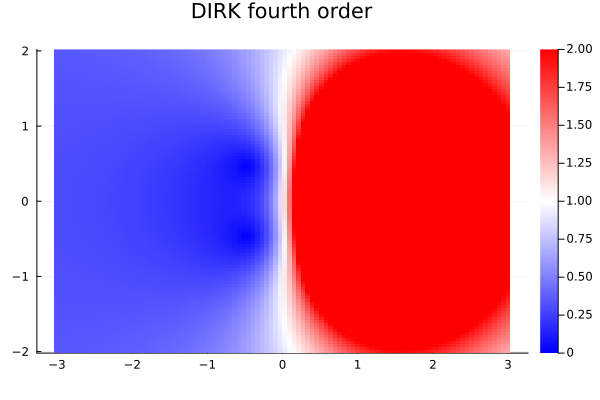

In [8]:
plot_stability(z -> rk_eff_stability(z, dirk4, brow=1), "DIRK fourth order")

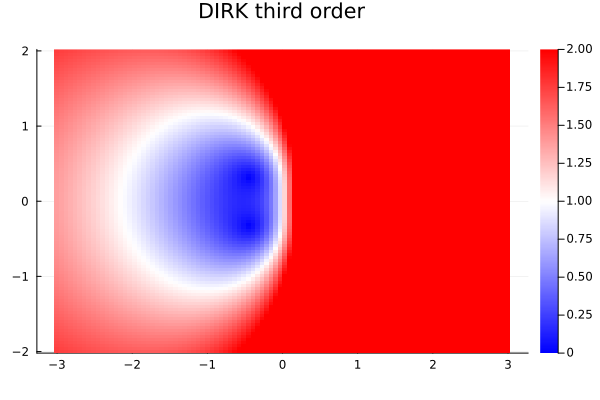

In [9]:
plot_stability(z -> rk_eff_stability(z, dirk4, brow=2), "DIRK third order")

# Fully implicit Runge-Kutta methods

<div class="floatright">

$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] $$
</div>

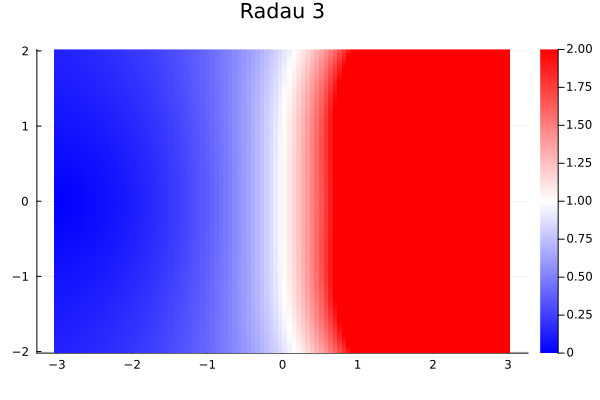

In [10]:
radau3 = RKTable([5/12 -1/12; 3/4 1/4], [3/4 1/4])
plot_stability(z -> rk_eff_stability(z, radau3), "Radau 3")

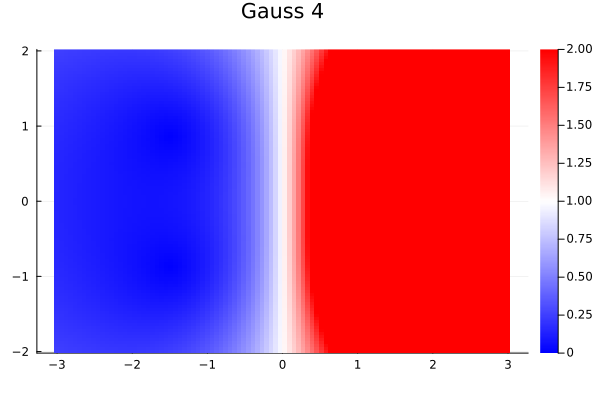

In [11]:
gauss4 = RKTable([1/4 1/4-sqrt(3)/6; 1/4+sqrt(3)/6 1/4],
    [1/2 1/2])
plot_stability(z -> rk_eff_stability(z, gauss4), "Gauss 4")

# Explore benchmarks: https://benchmarks.sciml.ai/

* Find at least one interesting figure
* You can work in groups

## Update your portfolio (will discuss in next class)

* Explain something about the figure
* Ask a question